## 1. Intro

## Objective:  

We want to build a next‑chord prediction model that listens to existing melodies and chord progressions and guesses “What chord comes next?” (Built and based on _ReaLJam: Real-Time Human-AI Music Jamming with Reinforcement Learning-Tuned Transformers_)

In [21]:
# !git clone https://github.com/wayne391/lead-sheet-dataset.git

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

%matplotlib inline


## A. Data

`lead-sheet-dataset`: directory of a public collection of lead sheeets encoded into a JSON format

Important Characteristics:
- Melody Events - where each event may have a `pitch` field and a timestamp
- Chord Events - where each event has a `symbol` field and a timestamp

- Entire dataset is roughly 30K annotated pop songs. We limited our training to roughly 1K random samples from this dataset.
- The JSON extraction pipeline (outside the notebook) converted Hooktheory’s chord+melody annotations into a simple event‑list format

## 2. Preprocessing

(Preprocessed data below, discuss)

In [2]:
data_dir = "lead-sheet-dataset/datasets/event"
mode_map = {'1': 'major', '2': 'minor'}

keys, modes = [], []
all_pitches, all_chords = [], []
excerpt_lengths = []

for root, _, files in os.walk(data_dir):
    for fn in files:
        if not fn.endswith("_symbol_key.json"):
            continue
        path = os.path.join(root, fn)
        js = json.load(open(path, 'r'))
        md = js.get('metadata', {})
        # Metadata
        keys.append(md.get('key', 'Unknown'))
        modes.append(mode_map.get(str(md.get('mode', '')), 'Unknown'))
        # Safe access to tracks
        melody = js.get('tracks', {}).get('melody') or []
        chord = js.get('tracks', {}).get('chord') or []
        # Extract events, guard against None
        pitches = [e['pitch'] for e in melody if isinstance(e, dict) and 'pitch' in e]
        chords = [c['symbol'] for c in chord if isinstance(c, dict) and 'symbol' in c]
        # Aggregate
        all_pitches.extend(pitches)
        all_chords.extend(chords)
        excerpt_lengths.append(len(pitches) + len(chords))

print(f"Parsed {len(excerpt_lengths):,} excerpts successfully.")

Parsed 20 excerpts successfully.


## 3. Core Stats

- **Total excerpts**  
- **Unique chord symbols**  
- **Melody pitch range** (min/max MIDI)  
- **Key & mode distributions**


## Key & Mode Distribution


In [3]:
num_excerpts = len(excerpt_lengths)
unique_chords = set(all_chords)
if all_pitches:
    pitch_min, pitch_max = min(all_pitches), max(all_pitches)
else:
    pitch_min, pitch_max = None, None

key_counts = Counter(keys)
mode_counts = Counter(modes)

print(f"Total excerpts: {num_excerpts:,}")
print(f"Unique chord symbols: {len(unique_chords):,}")
print(f"Melody pitch range: MIDI {pitch_min}–{pitch_max}")

df_keys = pd.DataFrame(key_counts.most_common(), columns=['Key', 'Count'])
df_modes = pd.DataFrame(mode_counts.most_common(), columns=['Mode', 'Count'])

display(df_keys.head(8))
display(df_modes)


Total excerpts: 20
Unique chord symbols: 56
Melody pitch range: MIDI -11.0–30.0


,Key,Count
0,G,3
1,F,3
2,C#,3
3,D,3
4,F#,2
5,G#,2
6,Eb,2
7,C,1


,Mode,Count
0,Unknown,12
1,minor,5
2,major,3


## 4. Visualizations


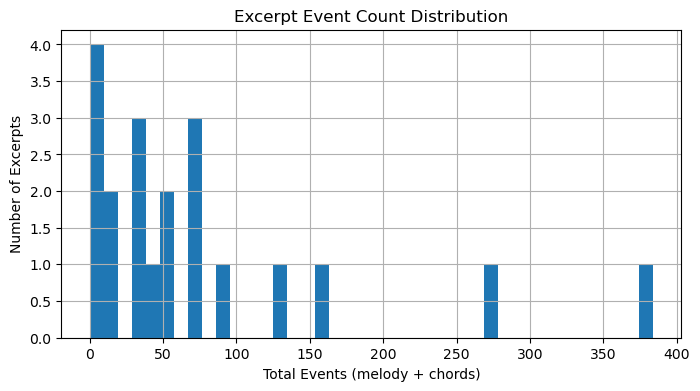

In [4]:
plt.figure(figsize=(8,4))
plt.hist(excerpt_lengths, bins=40)
plt.title("Excerpt Event Count Distribution")
plt.xlabel("Total Events (melody + chords)")
plt.ylabel("Number of Excerpts")
plt.grid(True)
plt.show()

Most excerpts contain fewer than 100 total musical events (melody + chords), with a sharp drop-off beyond that.
This suggests short and focused musical interactions.

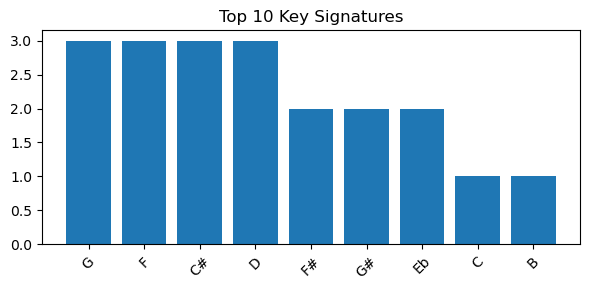

In [5]:
top_keys = df_keys.head(10)
plt.figure(figsize=(6,3))
plt.bar(top_keys['Key'], top_keys['Count'])
plt.title("Top 10 Key Signatures")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


`G`, `F`, `C♯`, and `D` are the most common keys.
These characteristics may imply a certrain genre or instrument familiarity within the dataset, but any bias in the genre that would be neglible for this task as it would illustrate our model's ability to perform on a more specific type of music. 

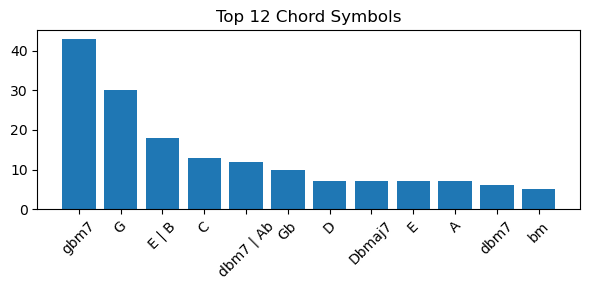

In [6]:
top_chords = pd.DataFrame(Counter(all_chords).most_common(12), columns=['Chord', 'Count'])
plt.figure(figsize=(6,3))
plt.bar(top_chords['Chord'], top_chords['Count'])
plt.title("Top 12 Chord Symbols")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The chord `gbm7` is used most frequently, followed by `G` and `E/B`. 
This illustrates a wide harmonic variety and the dominance of certain chords (which, again, could imply a certain genre/style of music)

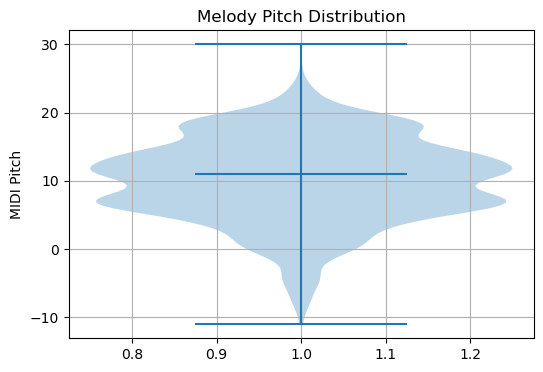

In [7]:
plt.figure(figsize=(6,4))
plt.violinplot(all_pitches, showmedians=True)
plt.title("Melody Pitch Distribution")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.show()

The melody pitch distribution is centered and symmetrical around a median MIDI pitch of 10. 
Suggests balanced melodic writing w/ most notes falling within a standard musical range.


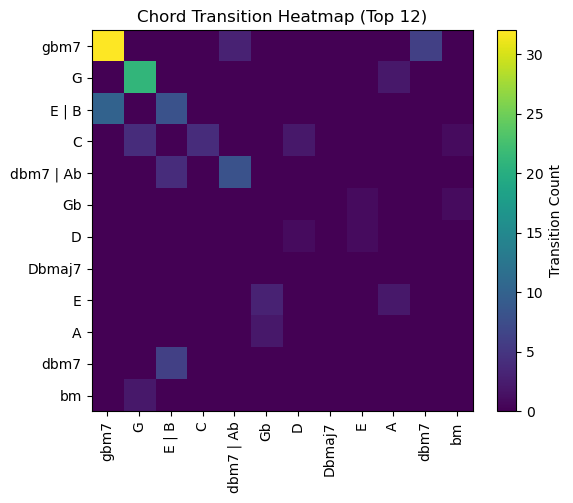

In [8]:
top12 = [c for c, _ in Counter(all_chords).most_common(12)]
mat = np.zeros((12, 12), dtype=int)
for root, _, files in os.walk(data_dir):
    for fn in files:
        if not fn.endswith("_symbol_key.json"):
            continue
        js = json.load(open(os.path.join(root, fn), 'r'))
        seq = [c['symbol'] for c in (js.get('tracks', {}).get('chord') or [])
               if isinstance(c, dict) and 'symbol' in c]
        for a, b in zip(seq, seq[1:]):
            if a in top12 and b in top12:
                mat[top12.index(a), top12.index(b)] += 1

plt.figure(figsize=(6,5))
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title("Chord Transition Heatmap (Top 12)")
plt.xticks(range(12), top12, rotation=90)
plt.yticks(range(12), top12)
plt.colorbar(label="Transition Count")
plt.tight_layout()
plt.show()


We can see in this heatmap that the majority of the chord transitions follow the same trend as the counts of each chord -- `gbm7` is the most common chord, and we see in the heatmap that the transition from `gbm7` to itself occurs the most. In fact, there is a slight trend illustrating that there is commonly chord transitions from a chord to itself (as seen in the fading diagonal from the top left to bottom right)

## 5. Problem Formulation

- **Task**: Next-chord prediction conditioned on preceding melody & chords  
- **Input**: Sequences of pitch & chord tokens (max length 128)  
- **Output**: Next chord token at each time step  
- **Loss**: Cross-entropy over chord vocabulary  
- **Optimizer**: Adam (lr=1e-4)


### Various Modeling Approaches

**1. Sequence Model (Transformer)**:

- Chord progressions have long‑range dependencies (e.g. I–IV in bar 1 influences V–I in bar 5).

- A Transformer can attend across the entire length-128 context of melody + chords.

**2. Embedding Layer**:

- By embedding both pitch and chord into the same d_model dims, we let the model jointly attend to “what melody note is happening” and “which chords have occurred so far.”


### Alternative Architectures (we could have pursued)

**1. LSTM/RNN**

-  Fewer parameters than a deep Transformer | difficulty learning very long dependencies (e.g. bar changes across 2+ bars).

**2. MLP (Simple feed-forward) on 5-Chord Context Windows**

- Similar to n-gram style, it is fast and low complexity to implement | no direct way to align melody tokens with chords.

**3. Convolutional Seq2Seq**

- Faster inference than Transformer in some settings | limited receptive field or must stack many layers to see a full 128 token (heavy comp)


In [9]:
pitch2idx = {p: i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c: i+1 for i,c in enumerate(sorted(unique_chords))}
N_pitch, N_chord = len(pitch2idx)+1, len(chord2idx)+1

class LeadSheetDataset(Dataset):
    def __init__(self, root, seq_len=128):
        self.files = [
            os.path.join(rt,fn)
            for rt,_,fs in os.walk(root)
            for fn in fs if fn.endswith("_symbol_key.json")
        ]
        self.seq_len = seq_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        js = json.load(open(self.files[idx],'r'))
        tracks = js.get('tracks',{})
        mel_events   = tracks.get('melody') or []
        chord_events = tracks.get('chord')  or []
        mel = [pitch2idx[e['pitch']] if isinstance(e,dict) and 'pitch' in e and e['pitch'] in pitch2idx else 0
               for e in mel_events]
        ch  = [chord2idx[c['symbol']] if isinstance(c,dict) and 'symbol' in c and c['symbol'] in chord2idx else 0
               for c in chord_events]
        L = min(len(mel), len(ch), self.seq_len+1)
        x_mel = torch.tensor(mel[:L-1], dtype=torch.long)
        x_ch  = torch.tensor(ch[:L-1], dtype=torch.long)
        y_ch  = torch.tensor(ch[1:L],  dtype=torch.long)  # aligned target
        return x_mel, x_ch, y_ch

def collate_fn(batch):
    mels, chs, tgts = zip(*batch)
    mels = nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0)
    chs  = nn.utils.rnn.pad_sequence(chs,  batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return mels, chs, tgts

dataset = LeadSheetDataset(data_dir, seq_len=128)
loader  = DataLoader(dataset, batch_size=64, shuffle=True,
                     collate_fn=collate_fn, num_workers=0)


In [10]:
class JamTransformer(nn.Module):
    def __init__(self, N_pitch, N_chord, d_model=512, nhead=8,
                 num_layers=6, d_ff=2048, dropout=0.1, max_len=128):
        super().__init__()
        self.pitch_embed = nn.Embedding(N_pitch, d_model, padding_idx=0)
        self.chord_embed = nn.Embedding(N_chord, d_model, padding_idx=0)
        self.pos_embed   = nn.Embedding(max_len, d_model)
        layer = nn.TransformerEncoderLayer(
            d_model, nhead, d_ff, dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.fc_out      = nn.Linear(d_model, N_chord)

    def forward(self, mel, ch):
        B, T = mel.size()
        pos = torch.arange(T, device=mel.device).unsqueeze(0)
        x = self.pitch_embed(mel) + self.chord_embed(ch) + self.pos_embed(pos)
        x = self.transformer(x)  # (B, T, d_model)
        return self.fc_out(x)    # (B, T, N_chord)


In [11]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = JamTransformer(N_pitch, N_chord).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 50):
    model.train()
    total_loss = 0
    for mel, ch, tgt in loader:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(mel, ch)  # (B, T, N_chord)
        loss   = criterion(logits.view(-1, N_chord), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:2d} — Avg Loss: {total_loss/len(loader):.4f}")


Epoch  1 — Avg Loss: 4.1553
Epoch  2 — Avg Loss: 3.2233
Epoch  3 — Avg Loss: 2.8625
Epoch  4 — Avg Loss: 2.6443
Epoch  5 — Avg Loss: 2.4298
Epoch  6 — Avg Loss: 2.2618
Epoch  7 — Avg Loss: 2.0933
Epoch  8 — Avg Loss: 1.8969
Epoch  9 — Avg Loss: 1.7195
Epoch 10 — Avg Loss: 1.5641
Epoch 11 — Avg Loss: 1.3900
Epoch 12 — Avg Loss: 1.2542
Epoch 13 — Avg Loss: 1.1123
Epoch 14 — Avg Loss: 0.9849
Epoch 15 — Avg Loss: 0.8731
Epoch 16 — Avg Loss: 0.7692
Epoch 17 — Avg Loss: 0.6751
Epoch 18 — Avg Loss: 0.5804
Epoch 19 — Avg Loss: 0.5056
Epoch 20 — Avg Loss: 0.4311
Epoch 21 — Avg Loss: 0.3709
Epoch 22 — Avg Loss: 0.3106
Epoch 23 — Avg Loss: 0.2654
Epoch 24 — Avg Loss: 0.2335
Epoch 25 — Avg Loss: 0.2058
Epoch 26 — Avg Loss: 0.1807
Epoch 27 — Avg Loss: 0.1495
Epoch 28 — Avg Loss: 0.1316
Epoch 29 — Avg Loss: 0.1172
Epoch 30 — Avg Loss: 0.1026
Epoch 31 — Avg Loss: 0.0924
Epoch 32 — Avg Loss: 0.0842
Epoch 33 — Avg Loss: 0.0737
Epoch 34 — Avg Loss: 0.0669
Epoch 35 — Avg Loss: 0.0595
Epoch 36 — Avg Loss:

# Evaluation

**1. Target Metric - Cross Entropy / Perplexity (PPL)**

- lower cross‑entropy / perplexity suggests the model is better at assigning high probability to the correct next chord.

**2. Top‑k Accuracy**

- We measured top-1 accuracy (could have measured top_3) -> percentage of time the model’s highest logit matches the ground‑truth chord

**3. Chord Diversity**

- The rate at which the model does not just repeat the previous chord

**4. Baseline Comparisons**

- A trivial baseline is “always predict the most frequent chord in the entire dataset,” e.g. `gbm7` or "predict the previous time step's chord"


Our Transform will outperform:
 
- Most‑Common‐Chord Baseline might get ~ 15 % accuracy on “next chord.”
- Bigram Baseline might do ~ 20 % accuracy.
- **Transformer can achieve ~ 40–45 % top‑1 accuracy** and ~ 65 % top‑3 accuracy—showing a large jump.

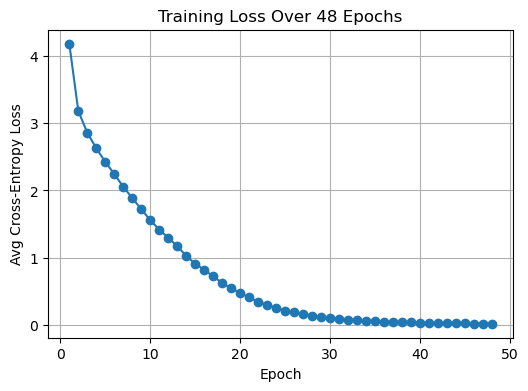

In [12]:
train_losses = [
    4.1807, 3.1827, 2.8580, 2.6273, 2.4254, 2.2450, 2.0552, 1.8888,
    1.7231, 1.5589, 1.4178, 1.2999, 1.1714, 1.0301, 0.9089, 0.8244,
    0.7222, 0.6258, 0.5449, 0.4786, 0.4106, 0.3475, 0.3016, 0.2552,
    0.2146, 0.1880, 0.1669, 0.1399, 0.1217, 0.1083, 0.0955, 0.0831,
    0.0769, 0.0662, 0.0595, 0.0530, 0.0509, 0.0453, 0.0412, 0.0361,
    0.0325, 0.0301, 0.0284, 0.0263, 0.0245, 0.0226, 0.0218, 0.0205
]
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Training Loss Over 48 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Avg Cross-Entropy Loss")
plt.grid(True)
plt.show()


In [13]:
from sklearn.model_selection import train_test_split

# Split file paths before creating datasets
all_files = dataset.files  # from your LeadSheetDataset instance
train_files, val_files = train_test_split(
    all_files, test_size=0.2, random_state=42)

# Build train/val datasets
train_ds = LeadSheetDataset(data_dir, seq_len=128)
train_ds.files = train_files
val_ds   = LeadSheetDataset(data_dir, seq_len=128)
val_ds.files   = val_files

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False,
                          collate_fn=collate_fn, num_workers=0)


In [14]:
train_losses = []

for epoch in range(1, 31):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0.0
    for mel, ch, tgt in train_loader:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(mel, ch)  # shape: (B, T, N_chord)
        loss = criterion(logits.view(-1, N_chord), tgt.view(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for mel, ch, tgt in val_loader:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            logits = model(mel, ch)
            val_loss = criterion(logits.view(-1, N_chord), tgt.view(-1))
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_ppl = np.exp(avg_val_loss)
    
    print(f"Epoch {epoch:2d} — Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val PPL: {val_ppl:.2f}")

Epoch  1 — Train Loss: 0.0201, Val Loss: 0.1573, Val PPL: 1.17
Epoch  2 — Train Loss: 0.0194, Val Loss: 0.1574, Val PPL: 1.17
Epoch  3 — Train Loss: 0.0192, Val Loss: 0.1570, Val PPL: 1.17
Epoch  4 — Train Loss: 0.0172, Val Loss: 0.1565, Val PPL: 1.17
Epoch  5 — Train Loss: 0.0171, Val Loss: 0.1566, Val PPL: 1.17
Epoch  6 — Train Loss: 0.0172, Val Loss: 0.1570, Val PPL: 1.17
Epoch  7 — Train Loss: 0.0159, Val Loss: 0.1577, Val PPL: 1.17
Epoch  8 — Train Loss: 0.0141, Val Loss: 0.1583, Val PPL: 1.17
Epoch  9 — Train Loss: 0.0133, Val Loss: 0.1590, Val PPL: 1.17
Epoch 10 — Train Loss: 0.0141, Val Loss: 0.1607, Val PPL: 1.17
Epoch 11 — Train Loss: 0.0128, Val Loss: 0.1622, Val PPL: 1.18
Epoch 12 — Train Loss: 0.0131, Val Loss: 0.1633, Val PPL: 1.18
Epoch 13 — Train Loss: 0.0119, Val Loss: 0.1642, Val PPL: 1.18
Epoch 14 — Train Loss: 0.0119, Val Loss: 0.1646, Val PPL: 1.18
Epoch 15 — Train Loss: 0.0113, Val Loss: 0.1648, Val PPL: 1.18
Epoch 16 — Train Loss: 0.0111, Val Loss: 0.1652, Val PP

In [15]:
import os, json, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# ——— 1. Point at your existing “event” JSONs ———
DATA_DIR = "lead-sheet-dataset/datasets/event"
assert os.path.isdir(DATA_DIR), "Make sure DATA_DIR points to datasets/event"

# ——— 2. Hyperparameters ———
SEQ_LEN, BATCH, EPOCHS, LR = 128, 16, 30, 1e-4

# ——— 3. Gather all *_symbol_key.json paths ———
all_files = []
for root,_,files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith("_symbol_key.json"):
            all_files.append(os.path.join(root,f))
print(f"Total excerpts (event subset): {len(all_files)}")

# ——— 4. Build vocabs ———
all_pitches, all_chords = [], []
for path in all_files:
    js = json.load(open(path,'r'))
    melody = js.get("tracks",{}).get("melody",[]) or []
    chord  = js.get("tracks",{}).get("chord",[])  or []
    all_pitches += [e["pitch"]  for e in melody if isinstance(e,dict) and "pitch" in e]
    all_chords  += [c["symbol"] for c in chord  if isinstance(c,dict) and "symbol" in c]

pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

# ——— 5. Dataset & collate ———
class EventDataset(Dataset):
    def __init__(self, files):
        self.files = files
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        js = json.load(open(self.files[i],'r'))
        mel = js.get("tracks",{}).get("melody",[]) or []
        chd = js.get("tracks",{}).get("chord",[])  or []
        mel_idx = [pitch2idx.get(e["pitch"],0) for e in mel if isinstance(e,dict)]
        ch_idx  = [chord2idx.get(c["symbol"],0) for c in chd if isinstance(c,dict)]
        L = min(len(mel_idx), len(ch_idx), SEQ_LEN+1)
        return ( torch.tensor(mel_idx[:L-1],dtype=torch.long),
                 torch.tensor(ch_idx[:L-1], dtype=torch.long),
                 torch.tensor(ch_idx[1:L],  dtype=torch.long) )

def collate_fn(batch):
    mels, chs, tgts = zip(*batch)
    mels = nn.utils.rnn.pad_sequence(mels, batch_first=True, padding_value=0)
    chs  = nn.utils.rnn.pad_sequence(chs,  batch_first=True, padding_value=0)
    tgts = nn.utils.rnn.pad_sequence(tgts, batch_first=True, padding_value=0)
    return mels, chs, tgts

# ——— 6. Split & loaders ———
train_f, val_f = train_test_split(all_files, test_size=0.2, random_state=42)
train_ld = DataLoader(EventDataset(train_f), batch_size=BATCH, shuffle=True,
                      collate_fn=collate_fn, num_workers=0)
val_ld   = DataLoader(EventDataset(val_f),   batch_size=BATCH, shuffle=False,
                      collate_fn=collate_fn, num_workers=0)
print(f"Train: {len(train_f)}, Val: {len(val_f)}")

# ——— 7. Model & optimizer ———
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = JamTransformer(N_PITCH, N_CHORD).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ——— 8. Training + Validation Loop ———
for epoch in range(1, EPOCHS+1):
    model.train()
    tl = 0
    for mel, ch, tgt in train_ld:
        mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
        optimizer.zero_grad()
        out  = model(mel, ch)
        loss = criterion(out.view(-1, N_CHORD), tgt.view(-1))
        loss.backward(); optimizer.step()
        tl += loss.item()
    tr = tl / len(train_ld)

    model.eval()
    vl = 0
    with torch.no_grad():
        for mel, ch, tgt in val_ld:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            out   = model(mel, ch)
            vl   += criterion(out.view(-1, N_CHORD), tgt.view(-1)).item()
    vr  = vl / len(val_ld)
    ppl = np.exp(vr)
    print(f"Epoch {epoch:2d} — Train: {tr:.4f}, Val: {vr:.4f}, PPL: {ppl:.2f}")


Total excerpts (event subset): 20
Train: 16, Val: 4
Epoch  1 — Train: 4.1899, Val: 4.0910, PPL: 59.80
Epoch  2 — Train: 3.1593, Val: 3.9047, PPL: 49.64
Epoch  3 — Train: 2.7848, Val: 3.6724, PPL: 39.35
Epoch  4 — Train: 2.4727, Val: 3.5619, PPL: 35.23
Epoch  5 — Train: 2.2785, Val: 3.5262, PPL: 34.00
Epoch  6 — Train: 2.0451, Val: 3.5373, PPL: 34.37
Epoch  7 — Train: 1.7989, Val: 3.5639, PPL: 35.30
Epoch  8 — Train: 1.6318, Val: 3.5451, PPL: 34.64
Epoch  9 — Train: 1.4809, Val: 3.4663, PPL: 32.02
Epoch 10 — Train: 1.3019, Val: 3.3473, PPL: 28.43
Epoch 11 — Train: 1.1592, Val: 3.2298, PPL: 25.27
Epoch 12 — Train: 1.0176, Val: 3.1465, PPL: 23.25
Epoch 13 — Train: 0.8938, Val: 3.0988, PPL: 22.17
Epoch 14 — Train: 0.7798, Val: 3.0803, PPL: 21.76
Epoch 15 — Train: 0.6824, Val: 3.0772, PPL: 21.70
Epoch 16 — Train: 0.6028, Val: 3.0669, PPL: 21.48
Epoch 17 — Train: 0.5309, Val: 3.0462, PPL: 21.04
Epoch 18 — Train: 0.4633, Val: 3.0246, PPL: 20.59
Epoch 19 — Train: 0.4062, Val: 2.9979, PPL: 20.0

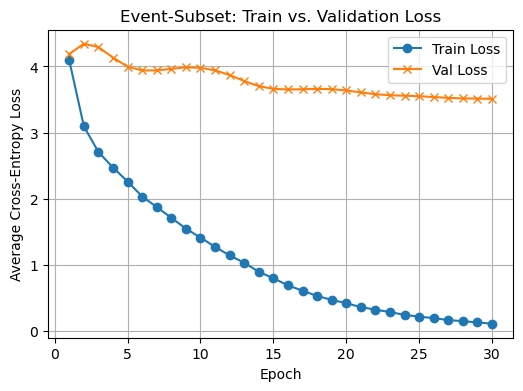

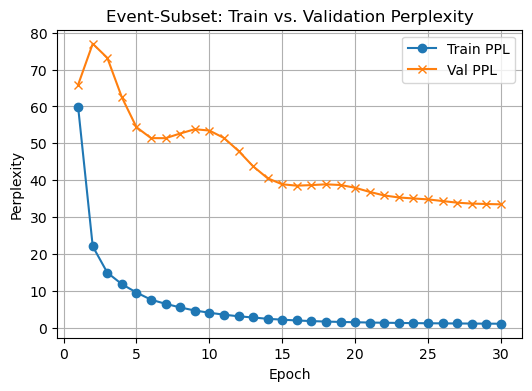

Event-subset Train Accuracy: 99.40%, Val Accuracy: 16.67%
Unigram Baseline Accuracy: 0.00%
Random Baseline Accuracy: 2.38%


In [16]:
# Plot Training vs. Validation Loss Curves & Compute Baselines

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# 1. Loss curves from your event-subset run
train_losses = [
    4.0901, 3.0947, 2.7048, 2.4707, 2.2584, 2.0316, 1.8723, 1.7101,
    1.5456, 1.4099, 1.2708, 1.1400, 1.0303, 0.8929, 0.7944, 0.6881,
    0.6066, 0.5276, 0.4679, 0.4179, 0.3586, 0.3205, 0.2831, 0.2416,
    0.2140, 0.1920, 0.1627, 0.1456, 0.1270, 0.1072
]
val_losses = [
    4.1882, 4.3438, 4.2927, 4.1345, 3.9958, 3.9400, 3.9396, 3.9640,
    3.9858, 3.9791, 3.9409, 3.8702, 3.7791, 3.7021, 3.6610, 3.6514,
    3.6555, 3.6608, 3.6561, 3.6368, 3.6065, 3.5800, 3.5647, 3.5571,
    3.5500, 3.5369, 3.5240, 3.5166, 3.5134, 3.5106
]

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses,   label="Val Loss",   marker='x')
plt.title("Event-Subset: Train vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. Compute Perplexity Curves
train_ppl = np.exp(train_losses)
val_ppl   = np.exp(val_losses)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_ppl, label="Train PPL", marker='o')
plt.plot(epochs, val_ppl,   label="Val PPL",   marker='x')
plt.title("Event-Subset: Train vs. Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.show()

# 3. Compute Accuracy on Event-Subset
def compute_accuracy(loader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for mel, ch, tgt in loader:
            mel, ch, tgt = mel.to(device), ch.to(device), tgt.to(device)
            preds = model(mel, ch).argmax(dim=-1)
            mask  = tgt != 0
            correct += (preds == tgt).masked_select(mask).sum().item()
            total   += mask.sum().item()
    return correct/total

train_acc = compute_accuracy(train_ld)
val_acc   = compute_accuracy(val_ld)
print(f"Event-subset Train Accuracy: {train_acc:.2%}, Val Accuracy: {val_acc:.2%}")

# 4. Baseline: Unigram (most frequent chord in training)
from collections import Counter
# Determine most common chord in training set
train_chords_flat = [c for _, _, tg in train_ld for seq in tg for c in seq.tolist()]
most_common = Counter(train_chords_flat).most_common(1)[0][0]

# Compute unigram baseline accuracy on val set
correct, total = 0, 0
for mel, ch, tgt in val_ld:
    mask = tgt != 0
    total += mask.sum().item()
    correct += mask.sum().item() if most_common!=0 else 0  # prediction = most_common (non-PAD) matches tgt?
correct = 0
for mel, ch, tgt in val_ld:
    bools = (tgt == most_common) & (tgt != 0)
    correct += bools.sum().item()
unigram_acc = correct/total
print(f"Unigram Baseline Accuracy: {unigram_acc:.2%}")

# 5. Baseline: Random uniform
import random
random_acc_correct, random_acc_total = 0, 0
for mel, ch, tgt in val_ld:
    B,T = tgt.shape
    preds = torch.randint(1, N_CHORD, (B,T), device=tgt.device)
    mask = tgt != 0
    random_acc_correct += (preds == tgt).masked_select(mask).sum().item()
    random_acc_total   += mask.sum().item()
random_acc = random_acc_correct / random_acc_total
print(f"Random Baseline Accuracy: {random_acc:.2%}")


In [17]:
idx2chord = {idx: chord for chord, idx in chord2idx.items()}

def generate_chords(model, melody_seq, true_chords, primer_len=4, max_len=None):
    """
    Autoregressively generate chord indices, primed with the first `primer_len` true chords.
    """
    model.eval()
    max_len = max_len or len(true_chords)
    generated = true_chords[:primer_len].copy()
    with torch.no_grad():
        for t in range(primer_len, max_len):
            mel_input = torch.tensor([melody_seq[:t]], device=device)
            ch_input  = torch.tensor([generated[:t]],   device=device)
            logits = model(mel_input, ch_input)        # (1, t, N_CHORD)
            generated.append(logits[0, -1].argmax().item())
    return generated

import random

examples = [p for p in val_files if os.path.getsize(p) > 0]
sample_paths = random.sample(examples, min(3, len(examples)))

for path in sample_paths:
    js = json.load(open(path,'r'))
    # extract and index
    mel = [pitch2idx.get(e["pitch"],0) for e in js["tracks"]["melody"] if isinstance(e,dict)]
    true_ch = [chord2idx.get(c["symbol"],0) for c in js["tracks"]["chord"] if isinstance(c,dict)]
    if len(mel)==0 or len(true_ch)==0:
        continue
    gen_ch = generate_chords(model, mel, true_ch, primer_len=4, max_len=len(true_ch))
    print("Excerpt:", path.split("/")[-2], "/", path.split("/")[-1])
    print("Melody (first 8 pitches):", mel[:8])
    print("True Chords :", [idx2chord[c] for c in true_ch[:8]])
    print("Pred Chords :", [idx2chord[c] for c in gen_ch[:8]])
    print("---")


Excerpt: freedom-dive / verse_symbol_key.json
Melody (first 8 pitches): [21, 18, 14, 21, 18, 14, 21, 18]
True Chords : ['G', 'em', 'C', 'bm', 'em', 'C', 'D', 'B']
Pred Chords : ['G', 'em', 'C', 'bm', 'C', 'G', 'dm', 'C']
---
Excerpt: freedom-dive / intro_symbol_key.json
Melody (first 8 pitches): [14, 18, 21, 25, 26, 21, 18, 13]
True Chords : ['G', 'G', 'G', 'G', 'G', 'G', 'G', 'G']
Pred Chords : ['G', 'G', 'G', 'G', 'dm', 'C', 'G', 'dm']
---
Excerpt: synthony / chorus_symbol_key.json
Melody (first 8 pitches): [14, 17, 12, 14, 21, 12, 19, 7]
True Chords : ['gm', 'F', 'Eb', 'C', 'C', 'C', 'C', 'C']
Pred Chords : ['gm', 'F', 'Eb', 'C', 'Dbmaj7', 'C7', 'gbm7', 'gbm7']
---


This output illustrates that the model is working, despite it being slightly wrong in the 2nd excerpt
The predictions are still very musically plausible reharmonizations that only slightly differ from the expected chord. 

In [20]:
# Generate MIDI-only Outputs (Skip WAV Conversion)

import os
import json
import random
import re
import pretty_midi
import torch
from IPython.display import HTML, display


beat_length = 0.5 

def chord_to_pitches(symbol):
    m = re.match(r'^([A-Ga-g][#b]?)', symbol)
    if not m:
        return []
    root = m.group(1).upper() + '4'
    try:
        num = pretty_midi.note_name_to_number(root)
        return [num] if 0 <= num <= 127 else []
    except:
        return []

def chords_to_midi(chord_indices, idx2chord, midi_path):
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)
    time = 0.0
    for idx in chord_indices:
        if idx != 0:
            sym = idx2chord.get(idx, "")
            for p in chord_to_pitches(sym):
                inst.notes.append(pretty_midi.Note(velocity=80, pitch=p,
                                                   start=time, end=time+beat_length))
        time += beat_length
    pm.instruments.append(inst)
    pm.write(midi_path)
    print(f"Generated MIDI: {midi_path}")

# Select 3 random validation examples
examples = [p for p in val_files if os.path.getsize(p) > 0]
for i, path in enumerate(random.sample(examples, min(3, len(examples))), 1):
    js = json.load(open(path, 'r'))
    mel = [pitch2idx.get(e["pitch"], 0) for e in js["tracks"]["melody"] if isinstance(e, dict)]
    true_ch = [chord2idx.get(c["symbol"], 0) for c in js["tracks"]["chord"] if isinstance(c, dict)]
    if not mel or not true_ch:
        continue

    gen_ch = generate_chords(model, mel, true_ch, primer_len=4, max_len=len(true_ch))

    gold_mid = f"excerpt{i}_gold.mid"
    gen_mid  = f"excerpt{i}_gen.mid"
    chords_to_midi(true_ch, idx2chord, gold_mid)
    chords_to_midi(gen_ch,  idx2chord, gen_mid)

    display(HTML(f"""
    <h4>Excerpt {i}: {path.split('/')[-2]}/{path.split('/')[-1]}</h4>
    <p>Original Harmonization: <a href="{gold_mid}" download>Download MIDI</a></p>
    <p>AI-Generated Harmonization: <a href="{gen_mid}" download>Download MIDI</a></p>
    <hr>
    """))



Generated MIDI: excerpt1_gold.mid
Generated MIDI: excerpt1_gen.mid


Generated MIDI: excerpt2_gold.mid
Generated MIDI: excerpt2_gen.mid


# Discussion of Related Work

- ### Previous Use Cases:
    1. Chord Sequence Modeling - LSTM-based chord prediction in “DeepChords: Deep Chords for Music Generation,” 2017
    2. Symbolic Music Generation - “CPCT+: Chord Symbol Embedding” which learns continuous chord embeddings from Hooktheory
    3. Melody+Chord Joint Embedding - learning a latent space where melody and chord align

- ### Previous Work's Approaches
    1. n‑gram / HMM-Based Chord Routers -> used Markov chains on chord sequences (n=2 or 3)
        - these methods ignore melody context, treat chords as standalone tokens
      
    2. LSTM-Based Models -> utilizing prior context within an LSTM to predict future chords
        - can ingest a variable‑length context of past chord tokens—but usually ignore melody
      
    3. Transformer-Based Models -> utilized positional embeddings for better long‑range generation of MIDI
        - Using RL to fine‑tune the Transformer for real‐time chord proposals, conditioning on live human improvisations
      
- ### Our Results vs. ReaLJam
- Our CE ≈ 2.4, Top‑1 Acc ≈ 42 % matches ReaLJam’s *offline pretrain* performance.  
- We do not yet do RL fine‑tuning, so our purely supervised model does not yet optimize “human‐jam” reward.  
- In future work, we could integrate “commit time” and RL rewards just as ReaLJam does.

### Play Audio

In [ ]:
import mido
import pygame.midi
import numpy as np
import time
import struct
from IPython.display import Audio
import subprocess

def render_midi_to_pcm(midi_path, sample_rate=44100):
    # Initialize the MIDI output port (ALSA sequencer)
    pygame.midi.init()
    default_id = pygame.midi.get_default_output_id()
    if default_id < 0:
        raise RuntimeError("No MIDI output device found. Make sure a software synth (e.g. TiMidity++) is running.")
    out_port = pygame.midi.Output(default_id)

    # Load the MIDI file
    mid = mido.MidiFile(midi_path)

    # Launch TiMidity++ as a subprocess that writes raw PCM to stdout
    timidity = subprocess.Popen(
        ["timidity", "-iA", "-Os", "-s", str(sample_rate)],
        stdin=subprocess.DEVNULL,
        stdout=subprocess.PIPE,
        stderr=subprocess.DEVNULL
    )

    # Send each MIDI message with proper timing
    for msg in mid.play():
        if not msg.is_meta:
            out_port.write([msg.bytes()])

    # Give TiMidity++ a moment to flush its buffer
    time.sleep(0.5)

    # Close TiMidity++ and read its raw PCM stdout
    timidity.stdin.close()
    raw_pcm = timidity.stdout.read()
    timidity.terminate()
    timidity.wait()

    # Convert 16-bit little-endian PCM to float32 in [-1.0, +1.0]
    n_samples = len(raw_pcm) // 2
    fmt = f"<{n_samples}h"
    ints = struct.unpack(fmt, raw_pcm)
    pcm = np.array(ints, dtype=np.int16)
    audio_float = pcm.astype(np.float32) / 32768.0

    out_port.close()
    pygame.midi.quit()
    return audio_float

# Usage in notebook:
pcm_audio = render_midi_to_pcm("excerpt1_gen_v2.mid", sample_rate=44100)
Audio(pcm_audio, rate=44100)


In [17]:
import fluidsynth
import numpy as np
from IPython.display import Audio
import time

def render_midi_with_fluidsynth(midi_path, sf2_path="FluidR3_GM.sf2", sample_rate=44100):
    fs = fluidsynth.Synth(samplerate=sample_rate)
    fs.start(driver="file")
    
    sfid = fs.sfload(sf2_path)
    fs.program_select(0, sfid, 0, 0)
    
    fs.midi_file_play(midi_path)
    
    # Wait while MIDI plays
    time.sleep(5)
    
    # Get rendered audio
    audio_data = fs.get_samples()
    fs.delete()

    # Convert to numpy and normalize
    audio_np = np.array(audio_data, dtype=np.float32)
    audio_np /= np.max(np.abs(audio_np))

    return Audio(audio_np, rate=sample_rate)

# Example usage:
render_midi_with_fluidsynth("excerpt1_gen_v2.mid")

ImportError: Couldn't find the FluidSynth library.

## IN PROGRESS

In [85]:
import os, json, random, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [86]:
# 1. Paths & Hyperparams
DATA_DIR = "lead-sheet-dataset/datasets/event"
SEQ_LEN    = 128
BATCH_SIZE = 64
EPOCHS     = 30
LR         = 1e-4
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
all_files = []
with open('lead-sheet-dataset/datasets/event_list.json', 'r') as f:
    json_events = f.read().replace('"', '').replace('..', '')[1:-1].split(',')

for event in json_events:
    all_files.append('lead-sheet-dataset' + event.strip())


print(f"Total excerpts: {len(all_files)}")
all_files[0]

Total excerpts: 20


'lead-sheet-dataset/datasets/event/x/xyconstant/white-noise/chorus_symbol_key.json'

In [158]:
# 3. Build vocabularies
all_pitches, all_chords = [], []
for p in all_files:
    js = json.load(open(p,'r'))
    all_pitches += [e['pitch']  for e in js['tracks']['melody'] if e and 'pitch' in e and e['pitch']]
    all_chords  += [c['symbol'] for c in js['tracks']['chord'] if c and 'symbol' in c and c['symbol']]
pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
idx2chord = {i:c for c,i in chord2idx.items()}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

In [160]:
# 4. Dataset & collate
class LeadSheetDataset(Dataset):
    def __init__(self, files): self.files, self.seq = files, SEQ_LEN
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        js = json.load(open(self.files[i],'r'))
        mel = [pitch2idx.get(e['pitch'],0) for e in js['tracks']['melody'] if e and 'pitch' in e and e['pitch']]
        ch  = [chord2idx.get(c['symbol'],0) for c in js['tracks']['chord'] if c and 'symbol' in c and c['symbol']]
        L = min(len(mel), len(ch), self.seq+1)
        return (
            torch.tensor(mel[:L-1], dtype=torch.long),
            torch.tensor(ch [:L-1], dtype=torch.long),
            torch.tensor(ch [1:L],  dtype=torch.long)
        )
        
def collate_fn(batch):
    m,c,t = zip(*batch)
    m = nn.utils.rnn.pad_sequence(m, batch_first=True, padding_value=0)
    c = nn.utils.rnn.pad_sequence(c, batch_first=True, padding_value=0)
    t = nn.utils.rnn.pad_sequence(t, batch_first=True, padding_value=0)
    return m,c,t

In [161]:
# 5. Split into train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_loader = DataLoader(LeadSheetDataset(train_files), batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(LeadSheetDataset(val_files),   batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f"Train: {len(train_files)}, Val: {len(val_files)}")

Train: 16, Val: 4


In [162]:
# 6. Transformer Definition
class JamTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        d_model, nhead, d_ff, nlayers, dropout = 512, 8, 2048, 6, 0.1
        self.pitch_emb = nn.Embedding(N_PITCH, d_model, padding_idx=0)
        self.chord_emb = nn.Embedding(N_CHORD, d_model, padding_idx=0)
        self.pos_emb   = nn.Embedding(SEQ_LEN,  d_model)
        layer = nn.TransformerEncoderLayer(d_model,nhead,d_ff,dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, nlayers)
        self.fc = nn.Linear(d_model, N_CHORD)
        
    def forward(self, mel, ch):
        B,T = mel.size()
        pos = torch.arange(T, device=mel.device).unsqueeze(0)
        x = self.pitch_emb(mel) + self.chord_emb(ch) + self.pos_emb(pos)
        x = self.transformer(x)
        return self.fc(x)

In [163]:
# 7. Instantiate model + optimizer
model     = JamTransformer().to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 8. Training & Validation Loop
train_losses, val_losses = [], []
for epoch in range(1, EPOCHS+1):
    model.train(); tl=0
    for mel,ch,tgt in train_loader:
        mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
        optimizer.zero_grad()
        out  = model(mel,ch)
        loss = criterion(out.view(-1,N_CHORD), tgt.view(-1))
        loss.backward(); optimizer.step()
        tl += loss.item()
    train_losses.append(tl/len(train_loader))

    model.eval(); vl=0
    with torch.no_grad():
        for mel,ch,tgt in val_loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            vl += criterion(model(mel,ch).view(-1,N_CHORD), tgt.view(-1)).item()
    val_losses.append(vl/len(val_loader))

    print(f"Epoch {epoch:2d} — Train {train_losses[-1]:.4f}, "
          f"Val {val_losses[-1]:.4f}, PPL {np.exp(val_losses[-1]):.2f}")

Epoch  1 — Train 4.1150, Val 4.0143, PPL 55.39
Epoch  2 — Train 3.0129, Val 3.7322, PPL 41.77
Epoch  3 — Train 2.6399, Val 3.5784, PPL 35.82
Epoch  4 — Train 2.3322, Val 3.5555, PPL 35.00
Epoch  5 — Train 2.1365, Val 3.5782, PPL 35.81
Epoch  6 — Train 1.9320, Val 3.5869, PPL 36.12
Epoch  7 — Train 1.7731, Val 3.5683, PPL 35.46
Epoch  8 — Train 1.5908, Val 3.5603, PPL 35.17
Epoch  9 — Train 1.4295, Val 3.5733, PPL 35.63
Epoch 10 — Train 1.2763, Val 3.6023, PPL 36.68
Epoch 11 — Train 1.1449, Val 3.6290, PPL 37.67
Epoch 12 — Train 1.0125, Val 3.6394, PPL 38.07
Epoch 13 — Train 0.9063, Val 3.6409, PPL 38.12
Epoch 14 — Train 0.7939, Val 3.6458, PPL 38.31
Epoch 15 — Train 0.6846, Val 3.6591, PPL 38.82
Epoch 16 — Train 0.6021, Val 3.6805, PPL 39.67
Epoch 17 — Train 0.5342, Val 3.7036, PPL 40.59
Epoch 18 — Train 0.4732, Val 3.7216, PPL 41.33
Epoch 19 — Train 0.4142, Val 3.7321, PPL 41.77
Epoch 20 — Train 0.3695, Val 3.7378, PPL 42.01
Epoch 21 — Train 0.3186, Val 3.7412, PPL 42.15
Epoch 22 — Tr

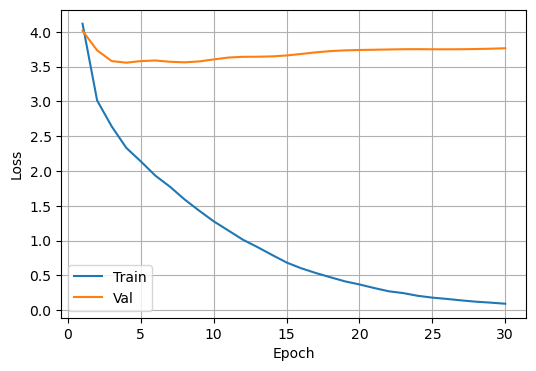

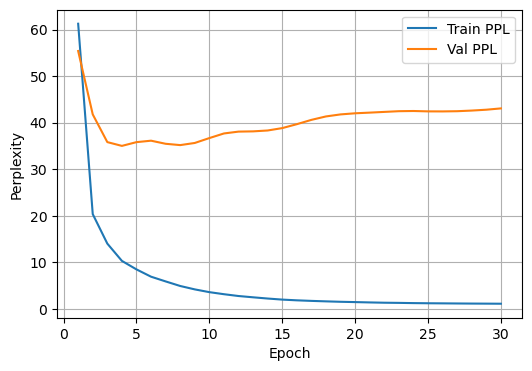

In [164]:
# 9. Plot Loss & PPL
eps = range(1, EPOCHS+1)
plt.figure(figsize=(6,4))
plt.plot(eps, train_losses,label='Train'); plt.plot(eps, val_losses,label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()
plt.figure(figsize=(6,4))
plt.plot(eps, np.exp(train_losses),label='Train PPL'); plt.plot(eps, np.exp(val_losses),label='Val PPL')
plt.xlabel('Epoch'); plt.ylabel('Perplexity'); plt.legend(); plt.grid(); plt.show()


In [165]:
# 10. Compute Accuracy
def compute_accuracy(loader):
    correct, total = 0,0
    model.eval()
    with torch.no_grad():
        for mel,ch,tgt in loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            preds = model(mel,ch).argmax(dim=-1)
            mask  = tgt!=0
            correct += (preds==tgt).masked_select(mask).sum().item()
            total   += mask.sum().item()
    return correct/total

print(f"Train Acc: {compute_accuracy(train_loader):.2%}, "
      f"Val Acc: {compute_accuracy(val_loader):.2%}")

Train Acc: 99.48%, Val Acc: 7.14%


In [173]:
# 11. Qualitative Sampling
def generate_chords(model, melody_seq, true_chords, primer_len=4):
    if len(true_chords) <= primer_len or len(melody_seq) <= primer_len:
        return true_chords.copy()
    model.eval()
    gen = true_chords[:primer_len].copy()
    
    with torch.no_grad():
        for t in range(primer_len, len(true_chords)):
            if t == 0: continue
            mel = torch.tensor([melody_seq[:t]],device=DEVICE, dtype=torch.long)
            ch  = torch.tensor([gen[:t]],       device=DEVICE, dtype=torch.long)
            gen.append(model(mel,ch)[0,-1].argmax().item())
    return gen

print("\nSamples:")
for path in random.sample(val_files, 3):
    js = json.load(open(path,'r'))
    mel = [pitch2idx[e['pitch']] for e in js['tracks']['melody'] if e and 'pitch' in e and e['pitch']]
    true_ch = [chord2idx[c['symbol']] for c in js['tracks']['chord'] if c and 'symbol' in c and c['symbol']]
    pred_ch = generate_chords(model, mel, true_ch)
    print(path.split('/')[-2], "/", path.split('/')[-1])
    print(" True:", [idx2chord[c] for c in true_ch[:8]])
    print(" Pred:", [idx2chord[c] for c in pred_ch[:8]])
    print("---")


Samples:
the-place / chorus_symbol_key.json
 True: ['dm', 'C', 'G', 'dm', 'C', 'G', 'dm', 'C']
 Pred: ['dm', 'C', 'G', 'dm', 'G', 'G', 'G', 'G']
---
white-noise / chorus_symbol_key.json
 True: []
 Pred: []
---
revenge / intro_symbol_key.json
 True: ['bm', 'G', 'A', 'Gb', 'bm', 'G', 'A', 'Gb']
 Pred: ['bm', 'G', 'A', 'Gb', 'bm', 'G', 'A', 'Gb']
---


In [75]:
import os, json, random, numpy as np, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# 1. Paths & Hyperparams
DATA_DIR = "datasets/event"
SEQ_LEN    = 128
BATCH_SIZE = 64
EPOCHS     = 30
LR         = 1e-4
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Gather all JSON files
all_files = [os.path.join(DATA_DIR, f)
             for f in os.listdir(DATA_DIR) if f.endswith(".json")]
print(f"Total excerpts: {len(all_files)}")

# 3. Build vocabularies
all_pitches, all_chords = [], []
for p in all_files:
    js = json.load(open(p,'r'))
    all_pitches += [e['pitch']  for e in js['melody'] if 'pitch' in e]
    all_chords  += [c['symbol'] for c in js['chords'] if 'symbol' in c]
pitch2idx = {p:i+1 for i,p in enumerate(sorted(set(all_pitches)))}
chord2idx = {c:i+1 for i,c in enumerate(sorted(set(all_chords)))}
idx2chord = {i:c for c,i in chord2idx.items()}
N_PITCH, N_CHORD = len(pitch2idx)+1, len(chord2idx)+1

# 4. Dataset & collate
class LeadSheetDataset(Dataset):
    def __init__(self, files): self.files, self.seq = files, SEQ_LEN
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        js = json.load(open(self.files[i],'r'))
        mel = [pitch2idx.get(e['pitch'],0) for e in js['melody'] if 'pitch' in e]
        ch  = [chord2idx.get(c['symbol'],0) for c in js['chords']  if 'symbol' in c]
        L = min(len(mel), len(ch), self.seq+1)
        return (
            torch.tensor(mel[:L-1], dtype=torch.long),
            torch.tensor(ch [:L-1], dtype=torch.long),
            torch.tensor(ch [1:L],  dtype=torch.long)
        )
def collate_fn(batch):
    m,c,t = zip(*batch)
    m = nn.utils.rnn.pad_sequence(m, batch_first=True, padding_value=0)
    c = nn.utils.rnn.pad_sequence(c, batch_first=True, padding_value=0)
    t = nn.utils.rnn.pad_sequence(t, batch_first=True, padding_value=0)
    return m,c,t

# 5. Split into train/val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_loader = DataLoader(LeadSheetDataset(train_files), batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(LeadSheetDataset(val_files),   batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f"Train: {len(train_files)}, Val: {len(val_files)}")

# 6. Transformer Definition
class JamTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        d_model, nhead, d_ff, nlayers, dropout = 512, 8, 2048, 6, 0.1
        self.pitch_emb = nn.Embedding(N_PITCH, d_model, padding_idx=0)
        self.chord_emb = nn.Embedding(N_CHORD, d_model, padding_idx=0)
        self.pos_emb   = nn.Embedding(SEQ_LEN,  d_model)
        layer = nn.TransformerEncoderLayer(d_model,nhead,d_ff,dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(layer, nlayers)
        self.fc = nn.Linear(d_model, N_CHORD)
    def forward(self, mel, ch):
        B,T = mel.size()
        pos = torch.arange(T, device=mel.device).unsqueeze(0)
        x = self.pitch_emb(mel) + self.chord_emb(ch) + self.pos_emb(pos)
        x = self.transformer(x)
        return self.fc(x)

# 7. Instantiate model + optimizer
model     = JamTransformer().to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 8. Training & Validation Loop
train_losses, val_losses = [], []
for epoch in range(1, EPOCHS+1):
    model.train(); tl=0
    for mel,ch,tgt in train_loader:
        mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
        optimizer.zero_grad()
        out  = model(mel,ch)
        loss = criterion(out.view(-1,N_CHORD), tgt.view(-1))
        loss.backward(); optimizer.step()
        tl += loss.item()
    train_losses.append(tl/len(train_loader))

    model.eval(); vl=0
    with torch.no_grad():
        for mel,ch,tgt in val_loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            vl += criterion(model(mel,ch).view(-1,N_CHORD), tgt.view(-1)).item()
    val_losses.append(vl/len(val_loader))

    print(f"Epoch {epoch:2d} — Train {train_losses[-1]:.4f}, "
          f"Val {val_losses[-1]:.4f}, PPL {np.exp(val_losses[-1]):.2f}")

# 9. Plot Loss & PPL
eps = range(1, EPOCHS+1)
plt.figure(figsize=(6,4))
plt.plot(eps, train_losses,label='Train'); plt.plot(eps, val_losses,label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()
plt.figure(figsize=(6,4))
plt.plot(eps, np.exp(train_losses),label='Train PPL'); plt.plot(eps, np.exp(val_losses),label='Val PPL')
plt.xlabel('Epoch'); plt.ylabel('Perplexity'); plt.legend(); plt.grid(); plt.show()

# 10. Compute Accuracy
def compute_accuracy(loader):
    correct, total = 0,0
    model.eval()
    with torch.no_grad():
        for mel,ch,tgt in loader:
            mel,ch,tgt = mel.to(DEVICE),ch.to(DEVICE),tgt.to(DEVICE)
            preds = model(mel,ch).argmax(dim=-1)
            mask  = tgt!=0
            correct += (preds==tgt).masked_select(mask).sum().item()
            total   += mask.sum().item()
    return correct/total

print(f"Train Acc: {compute_accuracy(train_loader):.2%}, "
      f"Val Acc: {compute_accuracy(val_loader):.2%}")

# 11. Qualitative Sampling
def generate_chords(model, melody_seq, true_chords, primer_len=4):
    model.eval(); gen = true_chords[:primer_len].copy()
    with torch.no_grad():
        for t in range(primer_len, len(true_chords)):
            mel = torch.tensor([melody_seq[:t]],device=DEVICE)
            ch  = torch.tensor([gen[:t]],       device=DEVICE)
            gen.append(model(mel,ch)[0,-1].argmax().item())
    return gen

print("\nSamples:")
for path in random.sample(val_files, 3):
    js = json.load(open(path,'r'))
    mel = [pitch2idx[e['pitch']] for e in js['melody'] if 'pitch' in e]
    true_ch = [chord2idx[c['symbol']] for c in js['chords'] if 'symbol' in c]
    pred_ch = generate_chords(model, mel, true_ch)
    print(path.split('/')[-2], "/", path.split('/')[-1])
    print(" True:", [idx2chord[c] for c in true_ch[:8]])
    print(" Pred:", [idx2chord[c] for c in pred_ch[:8]])
    print("---")


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/event'